### Pool of upwelled water and tracer for 10TR in Astoria and Barkley bathymetries

In [1]:
import cmocean as cmo
import canyon_tools.readout_tools as rout
import canyon_tools.savitzky_golay as sg
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import matplotlib.gridspec as gspec
import matplotlib.patches as pat
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_context('notebook')
sns.set_style('whitegrid')

In [4]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, nz, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = (np.ones(np.shape(BottomInd))*nz - BottomInd) # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[int(BottomInd[i,j]),i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def BottomAnom(Tr, hfac, ra, bathy,nz, sbdepth=-152.5):
    '''Tr: Tracer field-Tr field no canyon (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*nz - BottomInd # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[int(BottomInd[i,j]),i,j]
            if TrBottom > 0.0:
                ConcArea[i,j] = TrBottom*ra[i,j]
                Conc[i,j] = TrBottom
                Area[i,j] = ra[i,j]
            else:
                ConcArea[i,j] = np.NaN
                Conc[i,j] = np.NaN
                Area[i,j] = np.NaN
                

        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def PlotPool(ax,ConcFilt,X,Y,xslice,yslice,colmap, cmin=-1, cmax=1):
    
    BAC = ConcFilt[yslice,xslice]
    
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,20,
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.5,0.6,0.8,1.0,1.2],colors='k')
    plt.clabel(cs)
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

def PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                xslice_pl, yslice_pl, nz,
                hFacA, rAA, DepthA, XA, YA,
                hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        mesh1 = PlotPool(ax1,ConcLinA/nbl.variables[key][0,30,50,50],XA, YA,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh1, ax=ax1)
    
    with Dataset(ptr_fileB, 'r') as nbl:
        ConcAreaLinB, ConcLinB, AreaTrB = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacB,rAB,DepthB, nz-1,sbdepth=sbdepthB)
        mesh2 = PlotPool(ax2,ConcLinB/nbl.variables[key][0,40,50,50],XB, YB,
                         xslice_pl,yslice_pl, cmo.cm.matter, cmin=0, cmax=1.5)

    plt.colorbar(mesh2, ax=ax2)

    for ax in [ax1,ax2]:
        ax.set_facecolor("darkgrey")
        ax.set_ylabel('Cross-shelf / km')

    ax1.set_xlabel('CS distance / km')
    ax1.set_title('Astoria')
    ax2.set_xlabel('CS distance / km')
    ax2.set_title('Barkley day %1.1f' %(tt/2))

    ax1.set_aspect(1)
    return(ax1, ax2)

def GetPoolArea(tt, key, ptr_fileA, ptr_fileB,nz,
                hFacA, rAA, DepthA, 
                hFacB, rAB, DepthB, 
                sbdepthA=-150, sbdepthB=-200):
    
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        if key == 'Tr03':
            mask = np.ma.getmask(np.ma.masked_greater((ConcLinA/nbl.variables[key][0,30,50,50]), 1.0))
        else:
            mask = np.ma.getmask(np.ma.masked_less((ConcLinA/nbl.variables[key][0,30,50,50]), 1.0))

        Apool_Ast = np.ma.sum(np.ma.masked_array(AreaTrA, mask=mask))
        
    with Dataset(ptr_fileB, 'r') as nbl:
        ConcAreaLinB, ConcLinB, AreaTrB = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacB,rAB,DepthB, nz-1,sbdepth=sbdepthB)
        if key == 'Tr03':
            mask2 = np.ma.getmask(np.ma.masked_greater((ConcLinB/nbl.variables[key][0,40,50,50]), 1.0))
        else:    
            mask2 = np.ma.getmask(np.ma.masked_less((ConcLinB/nbl.variables[key][0,40,50,50]), 1.0))
        Apool_Bar = np.ma.sum(np.ma.masked_array(AreaTrB, mask=mask2))
        
    return(Apool_Ast, Apool_Bar)

def GetPoolConc(tt, key, ptr_fileA, ptr_fileB,nz,
                hFacA, rAA, DepthA, 
                hFacB, rAB, DepthB, 
                sbdepthA=-150, sbdepthB=-200):
    
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        if key == 'Tr03':
            mask = np.ma.getmask(np.ma.masked_greater((ConcLinA/nbl.variables[key][0,30,50,50]), 1.0))
        else:
            mask = np.ma.getmask(np.ma.masked_less((ConcLinA/nbl.variables[key][0,30,50,50]), 1.0))

        ConcPool_Ast = np.ma.mean(np.ma.masked_array(ConcAreaLinA/AreaTrA, mask=mask))
        
    with Dataset(ptr_fileB, 'r') as nbl:
        ConcAreaLinB, ConcLinB, AreaTrB = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacB,rAB,DepthB, nz-1,sbdepth=sbdepthB)
        if key == 'Tr03':
            mask2 = np.ma.getmask(np.ma.masked_greater((ConcLinB/nbl.variables[key][0,40,50,50]), 1.0))
        else:    
            mask2 = np.ma.getmask(np.ma.masked_less((ConcLinB/nbl.variables[key][0,40,50,50]), 1.0))
        ConcPool_Bar = np.ma.mean(np.ma.masked_array(ConcAreaLinB/AreaTrB, mask=mask2))
        
    return(ConcPool_Ast, ConcPool_Bar)

def GetBottomConc(tt, key, ptr_fileA, ptr_fileB,nz,
                  hFacA, rAA, DepthA, 
                  hFacB, rAB, DepthB, 
                  A_x0, A_x1, A_y0, A_y1,
                  B_x0, B_x1, B_y0, B_y1,
                  sbdepthA=-150, sbdepthB=-200):
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        ConcBottom_Ast = np.ma.mean(ConcAreaLinA[A_x0:A_x1,A_y0:A_y1]/AreaTrA[A_x0:A_x1,A_y0:A_y1])
        
    with Dataset(ptr_fileB, 'r') as nbl:
        ConcAreaLinB, ConcLinB, AreaTrB = BottomConc(nbl.variables[key][tt,:,:,:],
                                                     hFacB,rAB,DepthB, nz-1,sbdepth=sbdepthB)
        ConcBottom_Bar = np.ma.mean(ConcAreaLinB[B_x0:B_x1,B_y0:B_y1]/AreaTrB[B_x0:B_x1,B_y0:B_y1])
        
    return(ConcBottom_Ast, ConcBottom_Bar)


def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

def plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, 
                                         key, units, zslice, zsliceB, ZA, ZB,
                                         yindA, xindA, yindB, xindB):
    
    fig,ax = plt.subplots(2,4,figsize=(12,6), sharex=True)

    pal1 = sns.color_palette('Greens', 10)
    pal2 = sns.color_palette('Purples', 10)

    for ii in range(4):
        ax[0,ii].axhline(-20, color='0.8')

    for ii in range(4):
        for tt in range(0,19,2):

            tr = getProfile(ptr_fileA, maskCA, key, xindA[ii], yindA[ii], zslice, tt)
            trNoC = getProfile(ptr_fileANoC,maskCANoC, key, xindA[ii], yindA[ii], zslice, tt)
            ax[0,ii].plot(tr-trNoC, ZA[zslice],color=pal1[int(tt/2)], label='%d' %(tt/2))
         
    ax[0,1].set_title('St. 2')
    ax[0,2].set_title('St. 3')
    ax[0,3].set_title('St. 4')
    ax[0,0].set_title('%s Astoria, St. 1' %key)
    ax[0,0].set_ylabel('Depth / m')
    
    for ii in range(4):
        ax[1,ii].axhline(-20, color='0.8')
        ax[1,ii].set_xlabel(r'%s' %units)
    
    for ii in range(4):
        for tt in range(0,19,2):
            tr = getProfile(ptr_fileB, maskCB,key, xindB[ii], yindB[ii], zsliceB, tt)
            trNoC = getProfile(ptr_fileBNoC,maskCBNoC, key, xindB[ii], yindB[ii], zsliceB, tt)
            ax[1,ii].plot(tr-trNoC, ZB[zsliceB],color=pal2[int(tt/2)], label='%d' %(tt/2))
        
    ax[1,1].set_title('St. 2')
    ax[1,2].set_title('St. 3')
    ax[1,3].set_title('St. 3')
    ax[1,0].set_title('%s Barkley, St. 1' %key)
    ax[1,0].set_ylabel('Depth / m')
     
    ax[0,3].legend(bbox_to_anchor=(1,1))   
    ax[1,3].legend(bbox_to_anchor=(1,1))
    
def create_nc_file(pool_area, pool_conc,canyon_area, time, units, labels, filename, title, description):
    dataset = Dataset(filename, 'w',format='NETCDF4')
    dataset.title = title
    dataset.author = 'Karina Ramos Musalem'
    dataset.institution = 'Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia'
    dataset.source = 'bitbucket.org/canyonsubc/outputanalysisnotebooks/forPaper2/Pool_HCW_8Tr_Ast03_vs_Bar03.ipynb'
    dataset.description = description
    
    file_time = dataset.createDimension('time', len(time))
    file_tr = dataset.createDimension('tr', len(labels))
    
    file_area = dataset.createVariable('area', 'f8', ('tr','time'))
    file_conc = dataset.createVariable('conc', 'f8', ('tr','time'))
    file_area_can = dataset.createVariable('area_can', 'f8',())
    file_tr_names = dataset.createVariable('tr_names', 'str', ('tr'))
    file_time_v = dataset.createVariable('time', 'f8', ('time'))
    file_units = dataset.createVariable('units', 'str', ('tr'))
    
    file_time_v.standard_name = 'time'
    file_area.standard_name = 'Pool area'
    file_area_can.standard_name = 'Canyon area'
    file_tr_names.standard_name = 'tracer name'
    file_units.standard_name = 'tracer units'
    file_conc.standard_name = 'Pool concentration'
    
    file_area.units = 'm^2'
    file_area_can.units = 'm^2'    
    file_time_v.units = 's'
    
    file_area[:] = pool_area[:]
    file_conc[:] = pool_conc[:]
    file_area_can = canyon_area
    file_units = units
    file_tr_names = labels
    file_time_v[:] = time[:]
    
    dataset.close()
    
def create_nc_file_BAC(bac_conc, bac_noc, time, units, labels, filename, title, description):
    dataset = Dataset(filename, 'w',format='NETCDF4')
    dataset.title = title
    dataset.author = 'Karina Ramos Musalem'
    dataset.institution = 'Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia'
    dataset.source = 'bitbucket.org/canyonsubc/outputanalysisnotebooks/forPaper2/Pool_HCW_8Tr_Ast03_vs_Bar03.ipynb'
    dataset.description = description
    
    file_time = dataset.createDimension('time', len(time))
    file_tr = dataset.createDimension('tr', len(labels))
    
    file_bac = dataset.createVariable('bac', 'f8', ('tr','time'))
    file_bac_noc = dataset.createVariable('bac_noc', 'f8', ('tr','time'))
    file_tr_names = dataset.createVariable('tr_names', 'str', ('tr'))
    file_time_v = dataset.createVariable('time', 'f8', ('time'))
    file_units = dataset.createVariable('units', 'str', ('tr'))
    
    file_time_v.standard_name = 'time'
    file_bac.standard_name = 'bottom average concentration'
    file_tr_names.standard_name = 'tracer name'
    file_units.standard_name = 'tracer units'
    file_bac_noc.standard_name = 'bottom average concentration no canyon case'
    
    file_time_v.units = 's'
    
    file_bac[:] = bac_conc[:]
    file_bac_noc[:] = bac_noc[:]
    file_units = units
    file_tr_names = labels
    file_time_v[:] = time[:]
    
    dataset.close()

In [5]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/01_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF3_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF3_AST/01_Ast03/gridGlob.nc'

ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF3_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF3_AST/02_Ast03_No_Cny/gridGlob.nc'

In [6]:
nz = 104
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    DepthBNoC = nbl.variables['Depth'][:]
    rABNoC = nbl.variables['rA'][:]
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
    DepthANoC = nbl.variables['Depth'][:]
    rAANoC = nbl.variables['rA'][:]
    
with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]

### 01 - Initial profiles

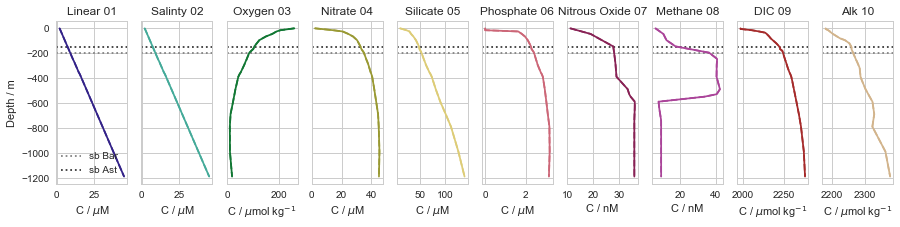

In [7]:
tracers = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels = ['Linear 01','Salinty 02','Oxygen 03','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07','Methane 08',
         'DIC 09', 'Alk 10']
units = ['(muM)m3/s','PSU','(umol/kg)m3/s','(muM)m3/s','(muM)m3/s','muM)m3/s','(nM)m3/s','(nM)m3/s','(umol/kg)m3/s','(umol/kg)m3/s']

#colours = ['purple','blue','green','gold','orange','red','orchid','teal']
colours = ['#332288','#44AA99','#117733','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'brown', 'tan']
fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)

sb_conc_A = np.empty(len(labels))
sb_conc_B = np.empty(len(labels))

for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style, sb_array, sb_ind in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--'],
                                                 [sb_conc_A, sb_conc_B], [sb_Ast, sb_Bar]):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            sb_array[ii] = tr_profile[sb_ind]

        ax[ii].plot(tr_profile, Z, color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM')
        elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
            ax[ii].set_xlabel('C / $\mu$mol kg$^{-1}$')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

Initial profiles. Profiles for both runs plotted to check they are actually the same.

#### Vertical tracer gradient

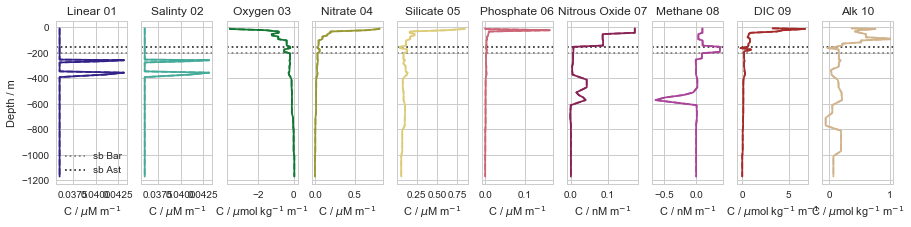

In [8]:
dTr_Ast = np.empty(len(tracers))
dTr_Bar = np.empty(len(tracers))
Tr_Ast = np.empty(len(tracers))
Tr_Bar = np.empty(len(tracers))

fig,ax = plt.subplots(1,len(tracers),figsize=(15,3), sharey = True)
    
for ii, trac, col, lab in zip(range(len(tracers)),tracers , colours, labels):

    ax[ii].axhline(-200, linestyle=':', color='0.5', label='sb Bar')
    ax[ii].axhline(-150, linestyle=':', color='0.2', label='sb Ast')
    
    for pfile, Z, style in zip([ptr_fileB, ptr_fileA],[ZB, ZA],['-', '--']):
        
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            dTrdz = (tr_profile[2:]-tr_profile[:-2])/(-Z[2:]+Z[:-2])  
            dTr_Ast[ii] = dTrdz[sb_Ast+1]/dTrdz[sb_Ast-1]
            dTr_Bar[ii] = dTrdz[sb_Bar+1]/dTrdz[sb_Bar-1]
            Tr_Ast[ii] = tr_profile[sb_Ast]
            Tr_Bar[ii] = tr_profile[sb_Bar]
            
        ax[ii].plot(dTrdz, Z[1:-1], color=col,linestyle=style)
        ax[ii].set_title(lab)
        
        if (trac == 'Tr07' or trac == 'Tr08'):
            ax[ii].set_xlabel('C / nM m$^{-1}$')
        elif (trac == 'Tr03' or (trac == 'Tr09' or trac == 'Tr10')):
            ax[ii].set_xlabel('C / $\mu$mol kg$^{-1}$ m$^{-1}$')
        else:
            ax[ii].set_xlabel(r'C / $\mu$M m$^{-1}$')

ax[0].set_ylabel('Depth / m')        
ax[0].legend(loc=0)

### 02 - Shelf-bottom pool 

Linear tracer (Tr01) 

Tracer gradients below shelf-break depth are the same for both canyons. This is the "base case" pool where both canyons have the same N,f, almost same U, and same dTr/dz at shelf-break depth.

Astoria: Length box is (target: 62.8 km) 
62.77664358706871
Astoria: Width box is (target: 43.6 km)
43.571296296296254
Barkley: Length box is (target: 52 km) 
52.261761985686725
Barkley: Width box is (target: 12.8 km)
12.83024691358024


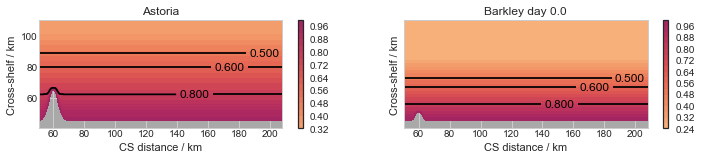

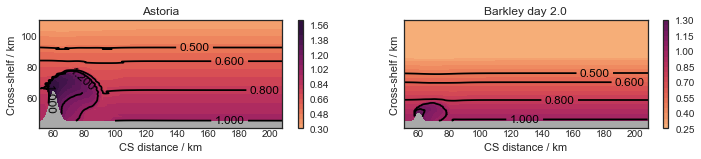

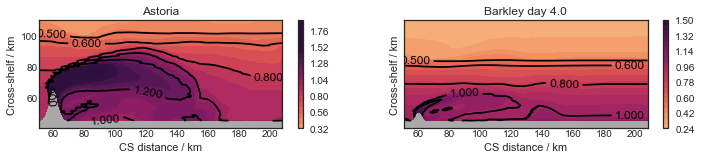

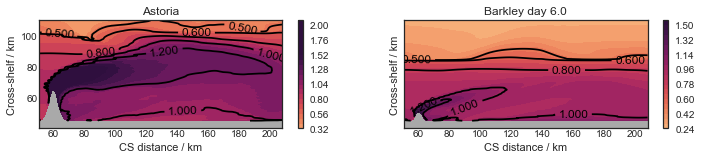

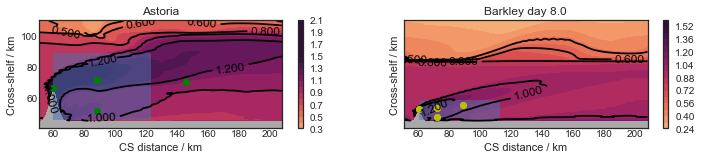

In [9]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr01'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)

yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

# define control area to calculate bottom concentration later on
ctrlA_x0 = 180
ctrlA_x1 = 364
ctrlA_y0 = 131
ctrlA_y1 = 312 
widthA = YA[ctrlA_y1]/1000-YA[ctrlA_y0]/1000
lengthA = XA[ctrlA_x1]/1000-XA[ctrlA_x0]/1000

print('Astoria: Length box is (target: 62.8 km) ')
print(lengthA)
print('Astoria: Width box is (target: 43.6 km)')
print(widthA)

ctrlB_x0 = 180
ctrlB_x1 = 347
ctrlB_y0 = 131
ctrlB_y1 = 198 
widthB = YB[ctrlB_y1]/1000-YB[ctrlB_y0]/1000
lengthB = XB[ctrlB_x1]/1000-XB[ctrlB_x0]/1000

print('Barkley: Length box is (target: 52 km) ')
print(lengthB)
print('Barkley: Width box is (target: 12.8 km)')
print(widthB)

rectA = pat.Rectangle((XA[ctrlA_x0]/1000,YA[ctrlA_y0]/1000),lengthA,widthA, angle=0.0, alpha=0.5)
ax1.add_patch(rectA)

rectB = pat.Rectangle((XB[ctrlB_x0]/1000,YB[ctrlB_y0]/1000),lengthB,widthB, angle=0.0, alpha=0.5)
ax2.add_patch(rectB)

#----------------------------------------------------------------

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    



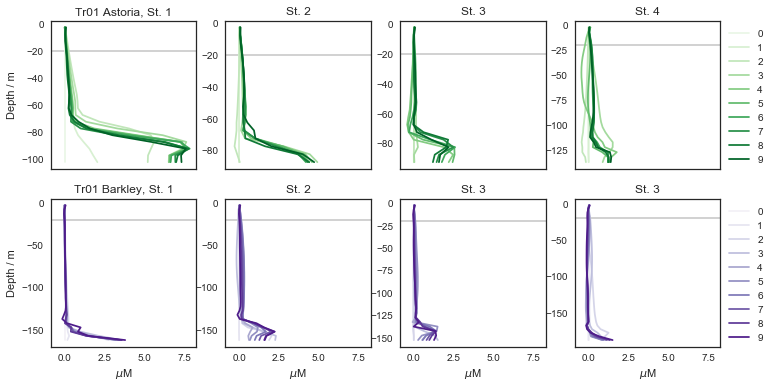

In [10]:
key = 'Tr01'
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

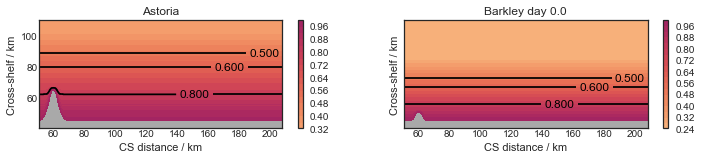

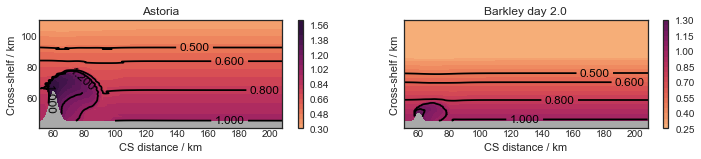

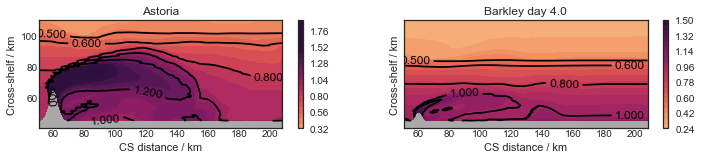

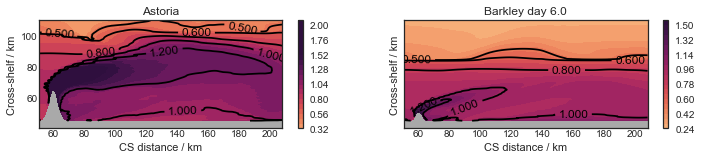

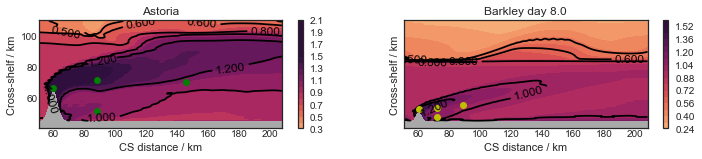

In [11]:
yslice_pl = slice(110,360)
xslice_pl = slice(120,500)

key = 'Tr01'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)

yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    
  

Salinity (Tr02)

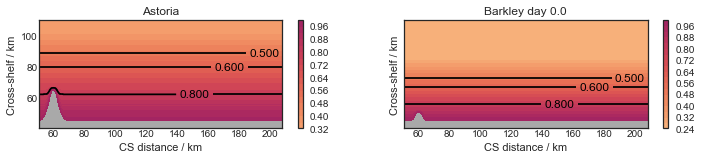

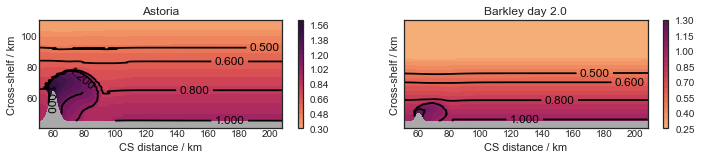

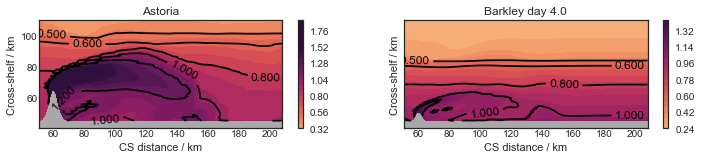

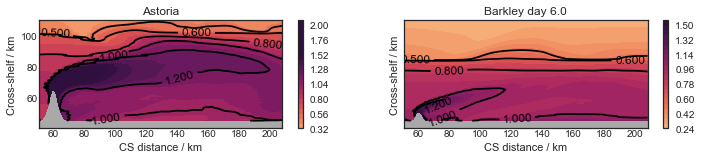

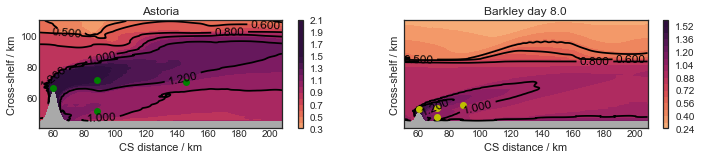

In [12]:
key = 'Tr02'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

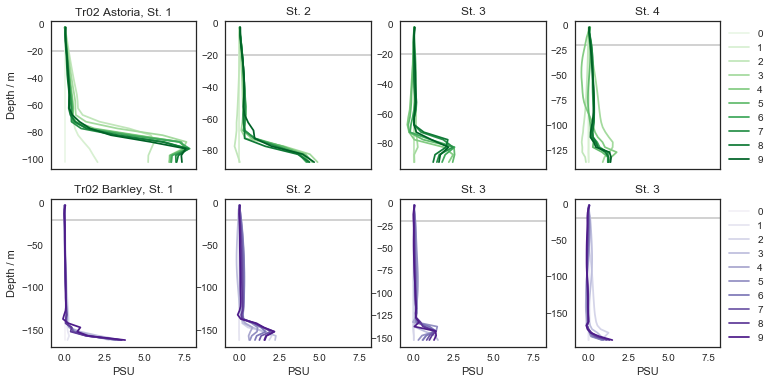

In [13]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'PSU'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Oxygen (Tr03)

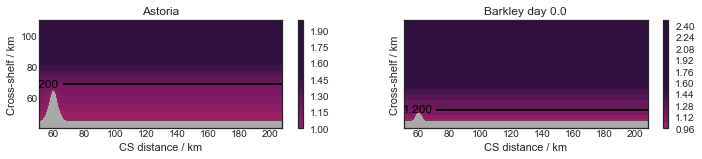

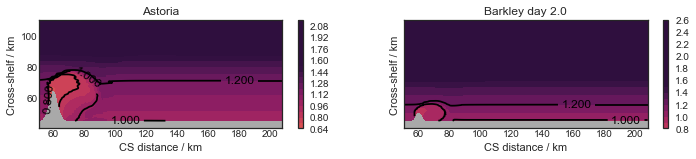

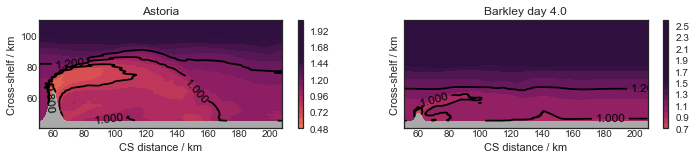

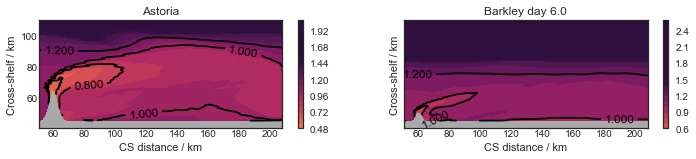

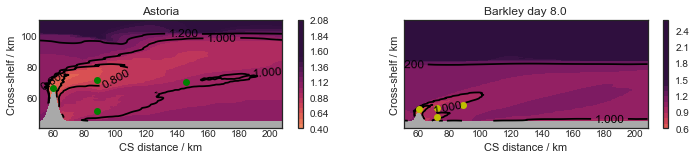

In [14]:
key = 'Tr03'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

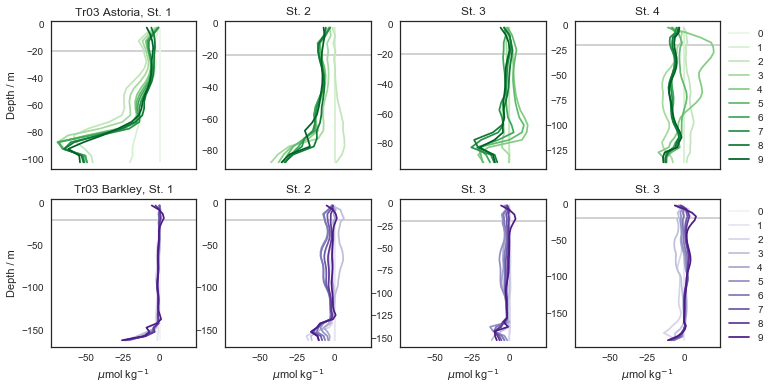

In [15]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$mol kg$^{-1}$'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Nitrate (Tr04)

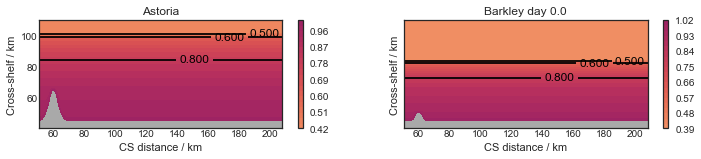

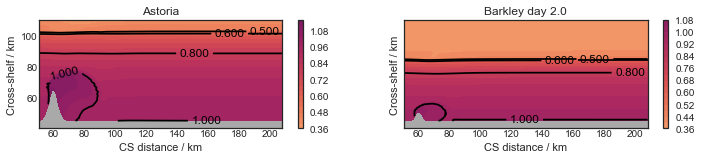

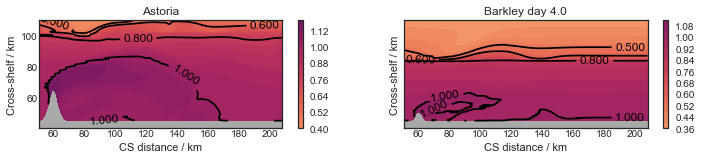

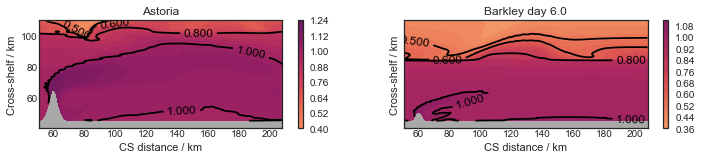

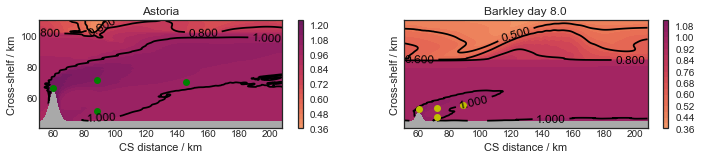

In [16]:
key = 'Tr04'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

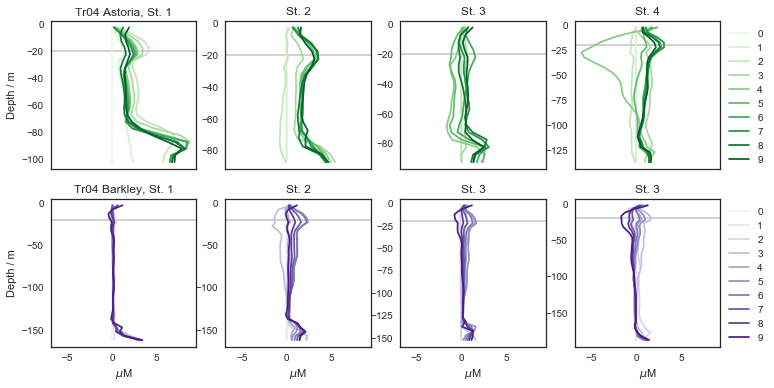

In [17]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Silicate (Tr05)

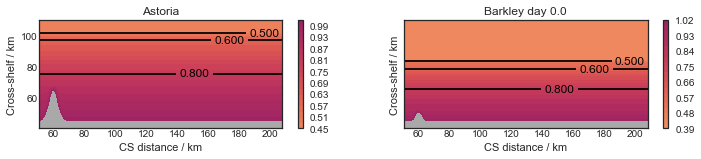

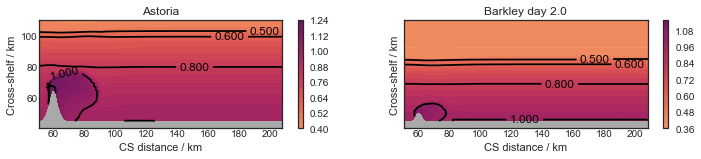

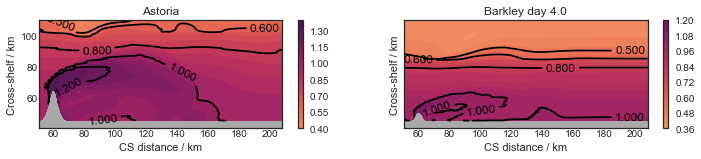

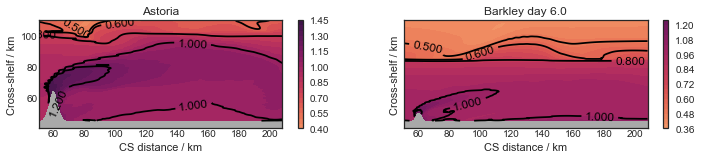

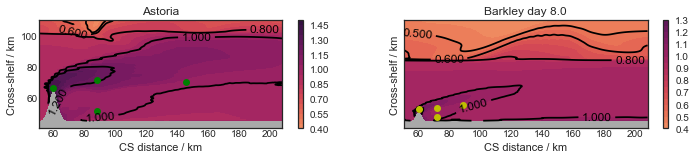

In [18]:
key = 'Tr05'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

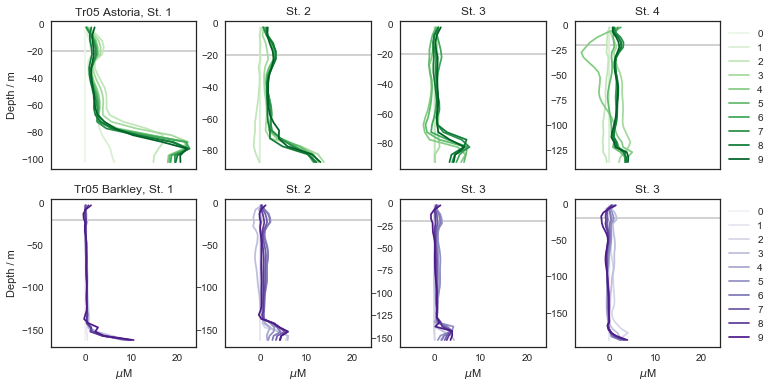

In [19]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Phosphate (Tr06)

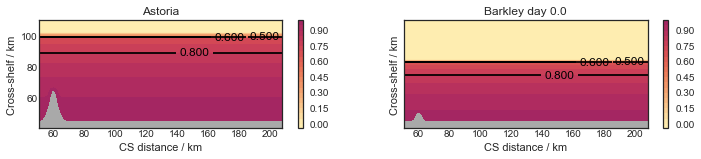

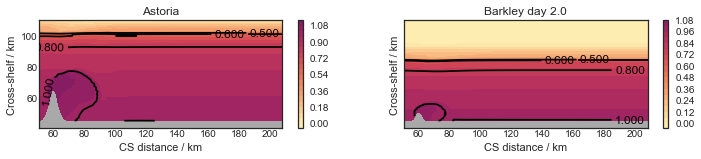

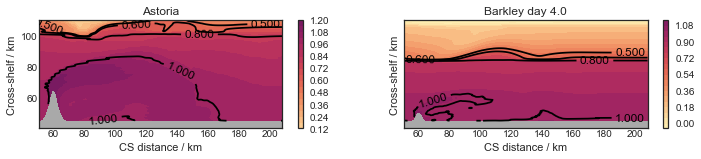

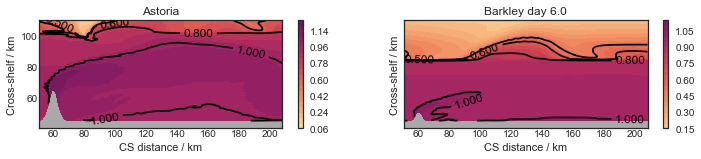

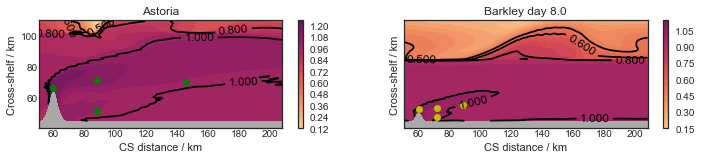

In [20]:
key = 'Tr06'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

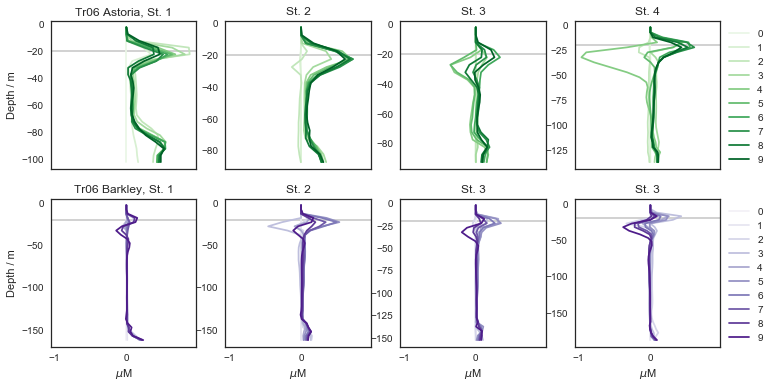

In [21]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Nitrous Oxide (Tr07)

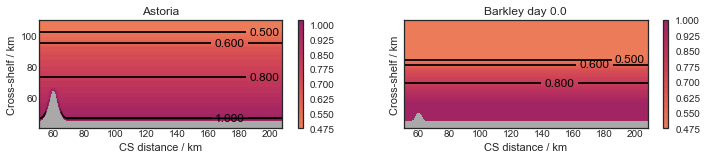

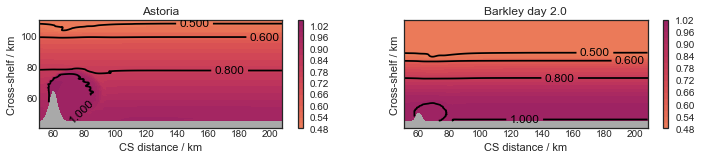

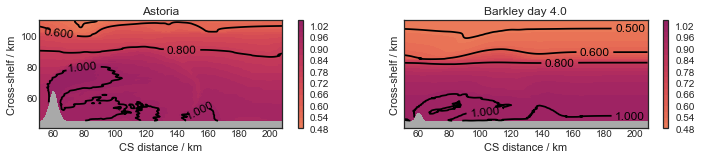

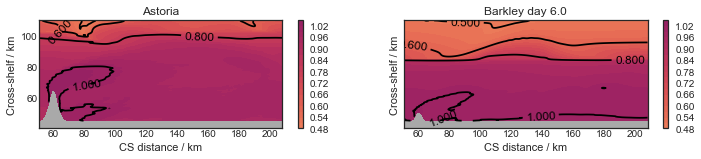

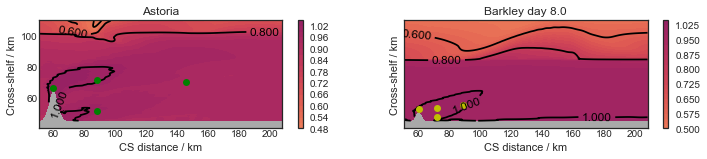

In [22]:
key = 'Tr07'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

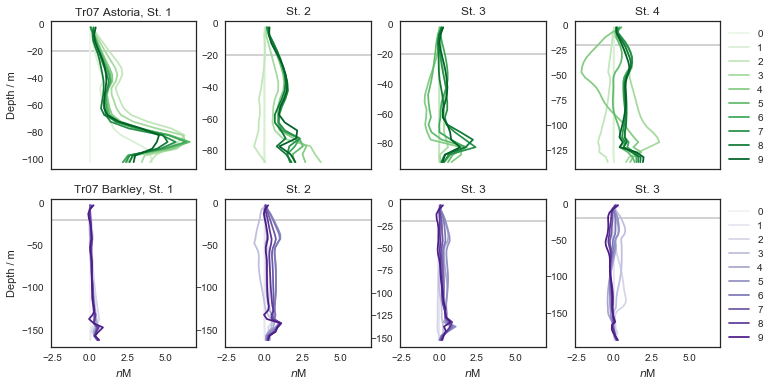

In [23]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$n$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Methane (Tr08)

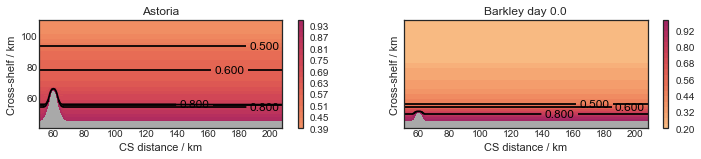

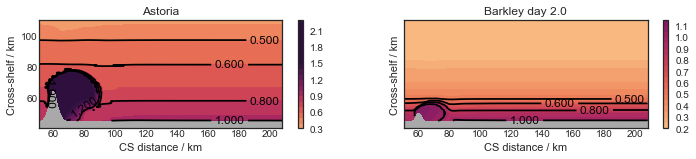

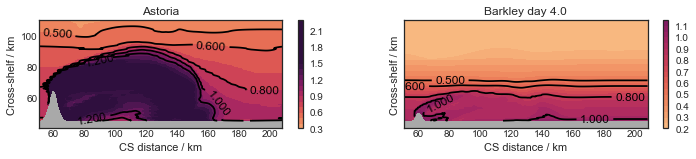

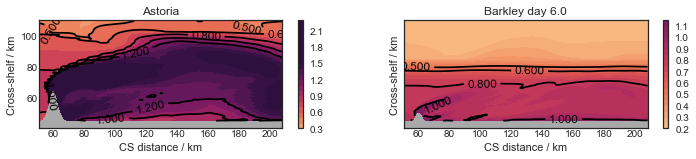

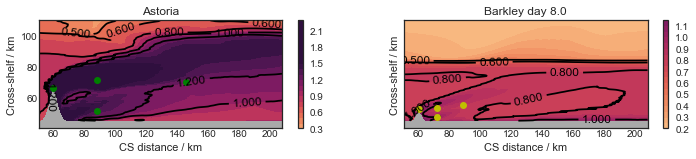

In [24]:
key = 'Tr08'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

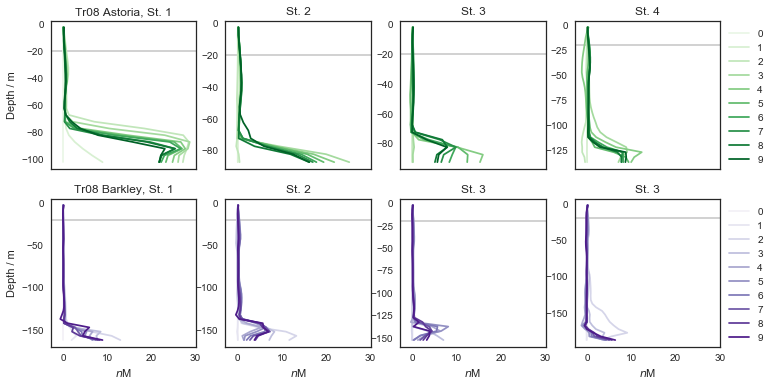

In [25]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$n$M'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


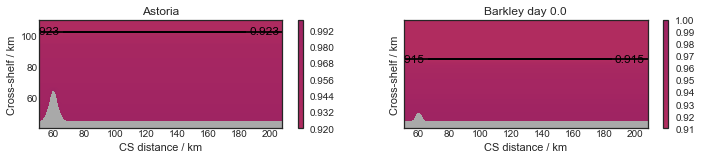

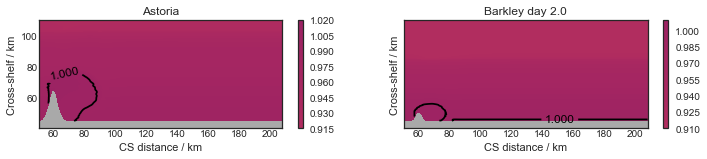

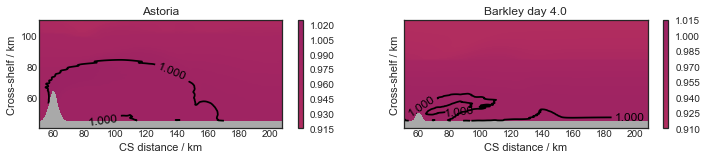

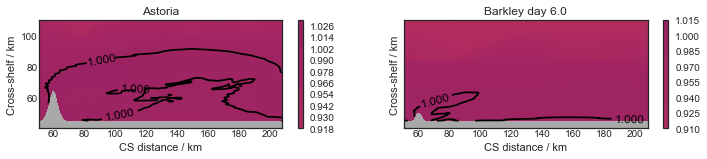

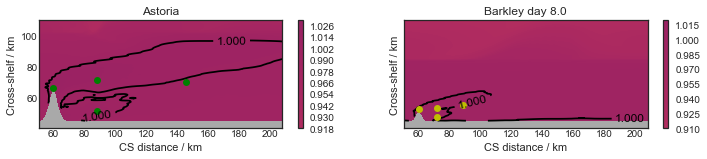

In [26]:
key = 'Tr09'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

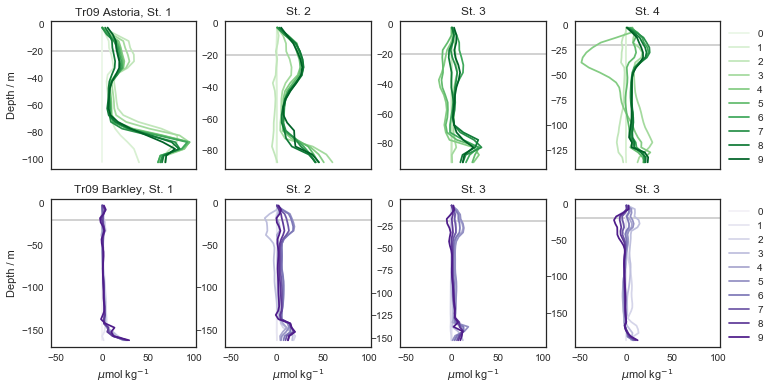

In [27]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$mol kg$^{-1}$'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


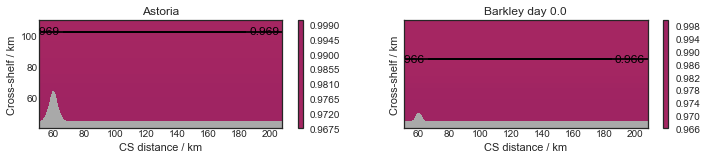

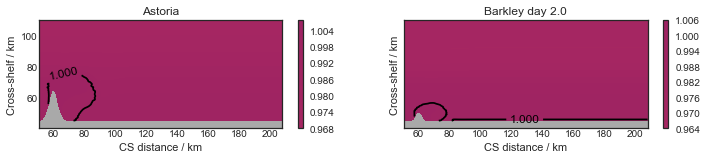

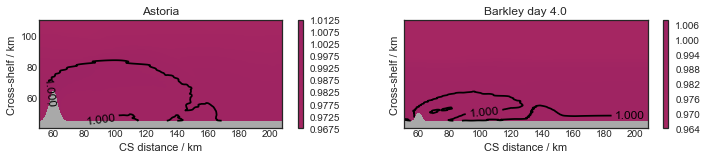

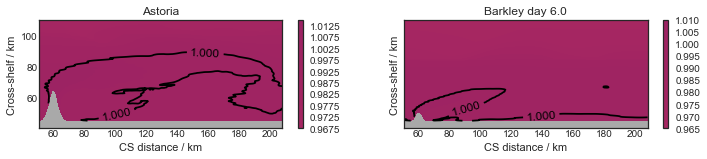

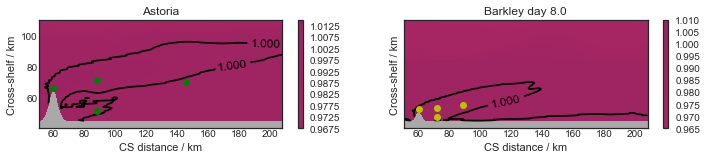

In [28]:
key = 'Tr10'

for tt in [0,4,8,12,16]:
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,2), sharey=True, sharex = True)
    
    ax1,ax2 = PlotPoolsTr(ax1, ax2, tt, key, ptr_fileA, ptr_fileB, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,
                          hFacB, rAB, DepthB, XB, YB, sbdepthA=-150, sbdepthB=-200)
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    

ax1.plot(XA[xindA]/1000, YA[yindA]/1000, 'og')
ax2.plot(XB[xindB]/1000, YB[yindB]/1000, 'oy')    

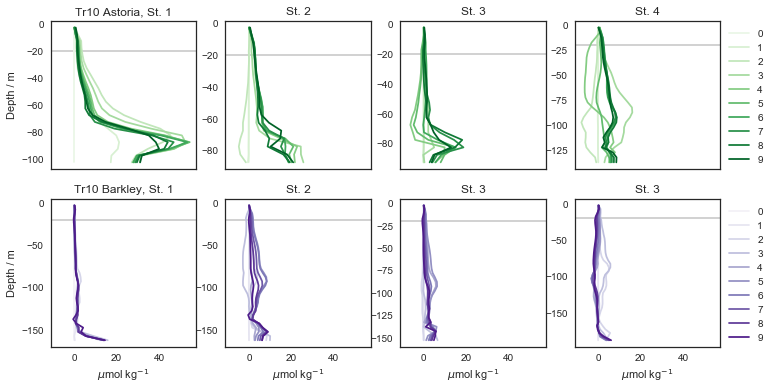

In [29]:
zslice = slice(0,30)
zsliceB = slice(0,50)
units = r'$\mu$mol kg$^{-1}$'

plot_pool_profiles(ptr_fileA, ptr_fileANoC, ptr_fileB, ptr_fileBNoC, key, units, zslice,
                   zsliceB, ZA, ZB, yindA, xindA, yindB, xindB)

Which one is larger?

Which one has higher concentration on average?

Depth of largest gradients vs shelf?

What matters is the tracer gradient below shelf break depth, but how deep is "below"? at shelf-break depth, Z (depth of upwelling), other scale?

Does gradient above matter?

Maybe I should also run a Barkley with same sb depth as Astoria or the opposite...

### HCW and tracer mass from all tracers

- HCW all calculated with lin tracer, but shouldn't it be the same for all tracers ideally? Ideally, I think so, but some profiles will be more diffusive (if they have large gradients) and thus, will find less upwelled water. By sticking to the linear profile we guaratee that we are counting tracer mass only on the same pool for water. How different is it to calculate HCW with lin or with each tracer?
- TrMass calculated using lin tracer to find cells with upwelled water and concetration from the tracer we are studying.

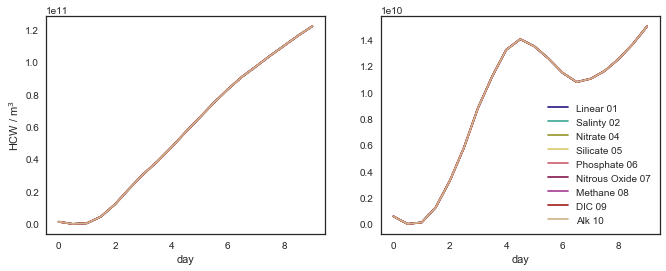

In [30]:
fig, ax = plt.subplots(1,2,figsize=(11,4))

tracers2 = ['Tr01','Tr02','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
labels2 = ['Linear 01','Salinty 02','Nitrate 04','Silicate 05','Phosphate 06','Nitrous Oxide 07',
           'Methane 08','DIC 09', 'Alk 10']
colours2 = ['#332288','#44AA99','#999933','#DDCC77','#CC6677','#882255','#AA4499', 'brown', 'tan']

for key, col, lab in zip(tracers2, colours2, labels2):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF3_AST/HCW_TrMass_%s_UPW_10TR_BF3_AST_01.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    HCW_Ast = df_Ast['HCW']
    ax[0].plot(np.arange(19)/2, HCW_Ast, color=col, label=lab)
    
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/HCW_TrMass_%s_UPW_10TR_BF5_BAR_01.csv' %key)
    df_Bar = pd.read_csv(f_Bar)
    HCW_Bar = df_Bar['HCW']
    ax[1].plot(np.arange(19)/2, HCW_Bar, color=col, label=lab)

ax[0].set_ylabel('HCW / m$^3$')
ax[0].set_xlabel('day')
ax[1].set_xlabel('day')

ax[1].legend(loc=0)

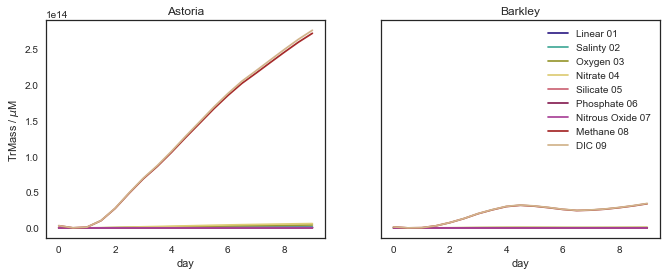

In [31]:
fig, ax = plt.subplots(1,2,figsize=(11,4), sharey=True)

for key, col, lab in zip(tracers2, colours2, labels):
    
    f_Ast = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF3_AST/HCW_TrMass_%s_UPW_10TR_BF3_AST_01.csv' %key)
    df_Ast = pd.read_csv(f_Ast)
    TrMass_Ast = df_Ast['TrMassHCW']
    
    if (key == 'Tr07') or (key == 'Tr08'):
        ax[0].plot(np.arange(19)/2, TrMass_Ast*1E-3, color=col, label=lab)
    else:
        ax[0].plot(np.arange(19)/2, TrMass_Ast, color=col, label=lab)
   
    f_Bar = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF5_BAR/HCW_TrMass_%s_UPW_10TR_BF5_BAR_01.csv' %key)
    df_Bar = pd.read_csv(f_Bar)
    TrMass_Bar = df_Bar['TrMassHCW']
    if (key == 'Tr07') or (key == 'Tr08'):
        ax[1].plot(np.arange(19)/2, TrMass_Bar*1E-3, color=col, label=lab)
    else:
        ax[1].plot(np.arange(19)/2, TrMass_Bar, color=col, label=lab)

ax[0].set_ylabel('TrMass / $\mu$M')
ax[0].set_xlabel('day')
ax[1].set_xlabel('day')
ax[0].set_title('Astoria')
ax[1].set_title('Barkley')

ax[1].legend(loc=0)


Here we are comparing muM but not all moles are the same. We are not making a fair comparison because the concentrations are so different. The change in methane on the shelf is huge compared to initial values but it is measured in nM.

### Pool size

In [32]:
# This cell is super slow

keys = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09','Tr10']
nt = 19
pool_B = np.empty((len(keys),nt))
pool_A = np.empty((len(keys),nt))
ii = 0

for key in keys:
    
    for tt in range(nt):
        pool_A[ii,tt], pool_B[ii,tt] = GetPoolArea(tt, key, ptr_fileA, ptr_fileB,nz, hFacA, rAA, 
                                                   DepthA, hFacB, rAB, DepthB, sbdepthA=-150, sbdepthB=-200)
    ii = ii+1


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Warning: converting a masked element to nan.


Text(0.5,1,'- - Barkley, - Astoria')

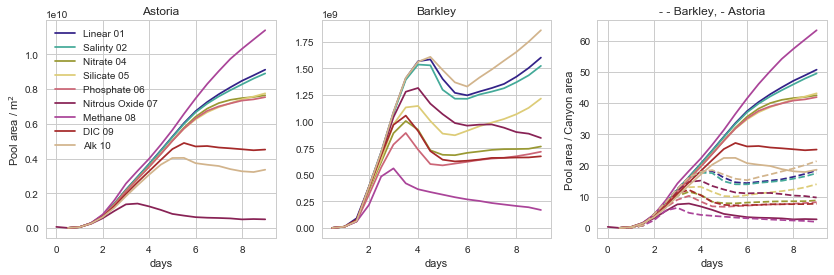

In [33]:
A_Ast = 1.8E8 # m^2
A_Bar = 8.7E7 # m^2

sns.set_style('whitegrid')
fig, ax = plt.subplots(1,3,figsize=(14,4))

for lab,col,ii in zip(labels2, colours2, [0,1,3,4,5,6,7,8,9]):
    ax[0].plot(np.arange(nt)/2,pool_A[ii,:], '-', color = col, label = lab)
    ax[1].plot(np.arange(nt)/2,pool_B[ii,:], '-', color = col)
    ax[2].plot(np.arange(nt)/2,pool_A[ii,:]/A_Ast, '-', color = col)
    ax[2].plot(np.arange(nt)/2,pool_B[ii,:]/A_Bar, '--', color = col)

for ii in range(len(ax)):
    ax[ii].set_xlabel('days')

ax[0].set_ylabel('Pool area / m$^{2}$')
ax[2].set_ylabel('Pool area / Canyon area')
ax[0].legend()
ax[0].set_title('Astoria')
ax[1].set_title('Barkley')
ax[2].set_title('- - Barkley, - Astoria')


If you approximate canyons as a triangle, their area would be:
   
   $A_{Ast} \approx$ 22 km $\times$ 16 km /2 = 1.8$\times10^{8}$ m$^2$
   
   $A_{Bar} \approx$ 6 km $\times$ 13 km /2 = 8.7$\times10^{7}$ m$^2$
   
   

Text(0.5,1,'Astoria: o, Barkley ^')

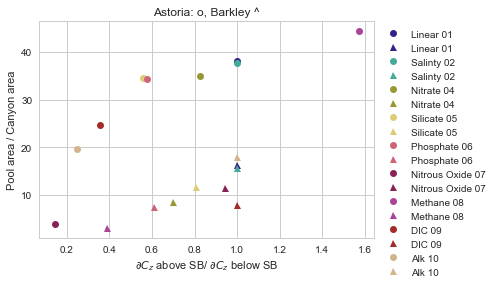

In [34]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1,figsize=(6,4))

for lab,col,ii in zip(labels2, colours2, [0,1,3,4,5,6,7,8,9]):
    ax.plot(dTr_Ast[ii],np.mean(pool_A[ii,8:])/A_Ast, 'o', color = col, label = lab)
    ax.plot(dTr_Bar[ii],np.mean(pool_B[ii,8:])/A_Bar, '^', color = col, label = lab)
   
ax.set_ylabel('Pool area / Canyon area')
ax.set_xlabel('$\partial C_z$ above SB/ $\partial C_z$ below SB')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Astoria: o, Barkley ^')


### Pool concentration

In [35]:
# This cell is super slow

keys = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09', 'Tr10']
nt = 19
Cpool_B = np.empty((len(keys),nt))
Cpool_A = np.empty((len(keys),nt))
ii = 0

for key in keys:
    
    for tt in range(nt):
        Cpool_A[ii,tt], Cpool_B[ii,tt] = GetPoolConc(tt, key, ptr_fileA, ptr_fileB,nz, hFacA, rAA, 
                                                     DepthA, hFacB, rAB, DepthB, sbdepthA=-150, sbdepthB=-200)
    print(key)
    ii = ii+1

/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Warning: converting a masked element to nan.


Tr01
Tr02
Tr03
Tr04
Tr05
Tr06
Tr07
Tr08
Tr09
Tr10


Text(0.5,1,'- - Barkley, - Astoria')

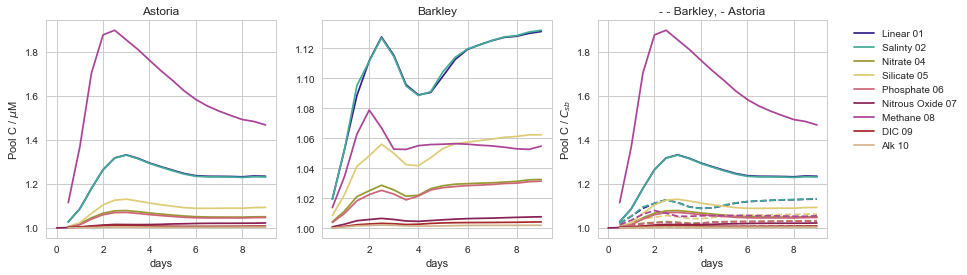

In [36]:
A_Ast = 1.8E8 # m^2
A_Bar = 8.7E7 # m^2

sns.set_style('whitegrid')
fig, ax = plt.subplots(1,3,figsize=(14,4))

for lab,col,ii in zip(labels2, colours2, [0,1,3,4,5,6,7,8,9]):
    ax[0].plot(np.arange(nt)/2,Cpool_A[ii,:]/Tr_Ast[ii], '-', color = col, label = lab)
    ax[1].plot(np.arange(nt)/2,Cpool_B[ii,:]/Tr_Bar[ii], '-', color = col)
    ax[2].plot(np.arange(nt)/2,Cpool_A[ii,:]/Tr_Ast[ii], '-', color = col)
    ax[2].plot(np.arange(nt)/2,Cpool_B[ii,:]/Tr_Bar[ii], '--', color = col)

for ii in range(len(ax)):
    ax[ii].set_xlabel('days')

ax[0].set_ylabel(r'Pool C / $\mu$M')
ax[2].set_ylabel(r'Pool C / $C_{sb}$')
ax[0].legend(bbox_to_anchor=(4,1))
ax[0].set_title('Astoria')
ax[1].set_title('Barkley')
ax[2].set_title('- - Barkley, - Astoria')


Text(0.5,1,'Astoria: o, Barkley ^')

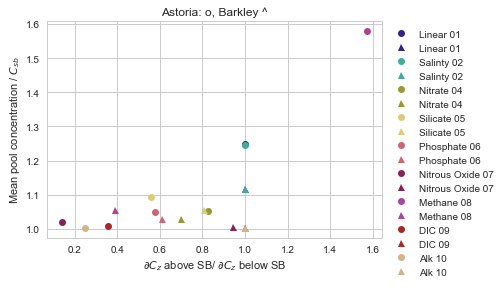

In [37]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,1,figsize=(6,4))

for lab,col,ii in zip(labels2, colours2, [0,1,3,4,5,6,7,8,9]):
    ax.plot(dTr_Ast[ii],np.mean(Cpool_A[ii,8:]/Tr_Ast[ii]), 'o', color = col, label = lab)
    ax.plot(dTr_Bar[ii],np.mean(Cpool_B[ii,8:]/Tr_Bar[ii]), '^', color = col, label = lab)
   
ax.set_ylabel('Mean pool concentration / $C_{sb}$')
ax.set_xlabel('$\partial C_z$ above SB/ $\partial C_z$ below SB')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Astoria: o, Barkley ^')


In [38]:
filename = 'saved_calcs/pool_AST_BF3.nc'
description = 'Area and mean concentration of pool of upwelled tracer for Astoria run'
title = 'Pool concentration and area'
create_nc_file(pool_A, Cpool_A, A_Ast,time, units, labels, filename, title, description)

In [39]:
filename='saved_calcs/pool_AST_BF3.nc'
with Dataset(filename, 'r') as nbl:
    print(nbl.variables['area_can'])

<class 'netCDF4._netCDF4.Variable'>
float64 area_can()
    standard_name: Canyon area
    units: m^2
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of 9.969209968386869e+36 used



In [40]:
filename = 'saved_calcs/pool_BAR_BF5.nc'
description = 'Area and mean concentration of pool of upwelled tracer for Barkley run'
title = 'Pool concentration and area'
create_nc_file(pool_B, Cpool_B, A_Bar,time, units, labels, filename, title, description)

### Bottom concentration on control area (canyon and no canyon runs)


In [41]:
keys = ['Tr01','Tr02','Tr03','Tr04','Tr05','Tr06','Tr07','Tr08','Tr09', 'Tr10']
nt = 19
Cbottom_B = np.empty((len(keys),nt))
Cbottom_A = np.empty((len(keys),nt))

Cbottom_BNoC = np.empty((len(keys),nt))
Cbottom_ANoC = np.empty((len(keys),nt))

ii = 0

for key in keys:
    
    for tt in range(nt):
        Cbottom_A[ii,tt], Cbottom_B[ii,tt] = GetBottomConc(tt, key, ptr_fileA, ptr_fileB,nz, hFacANoC, 
                                                           rAANoC, DepthANoC, hFacBNoC, rABNoC, DepthBNoC,
                                                           ctrlA_x0, ctrlA_x1,ctrlA_y0, ctrlA_y1,
                                                           ctrlB_x0, ctrlB_x1,ctrlB_y0, ctrlB_y1,
                                                           sbdepthA=-150, sbdepthB=-200)
        Cbottom_ANoC[ii,tt], Cbottom_BNoC[ii,tt] = GetBottomConc(tt, key, ptr_fileANoC, ptr_fileBNoC,nz, hFacANoC, 
                                                                 rAANoC, DepthANoC, hFacBNoC, rABNoC, DepthBNoC,
                                                                 ctrlA_x0, ctrlA_x1,ctrlA_y0, ctrlA_y1,
                                                                 ctrlB_x0, ctrlB_x1,ctrlB_y0, ctrlB_y1,
                                                                 sbdepthA=-150, sbdepthB=-200)
    ii = ii+1



Text(0.5,1,'- - Barkley, - Astoria')

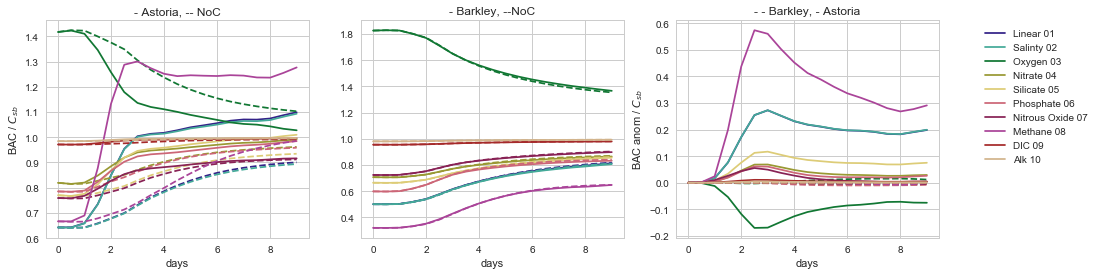

In [42]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(1,3,figsize=(16,4))

for lab,col,ii in zip(labels, colours, [0,1,2,3,4,5,6,7,8,9]):
    ax[0].plot(np.arange(nt)/2,Cbottom_A[ii,:]/Tr_Ast[ii], '-', color = col, label = lab)
    ax[0].plot(np.arange(nt)/2,Cbottom_ANoC[ii,:]/Tr_Ast[ii], '--', color = col)
    
    ax[1].plot(np.arange(nt)/2,Cbottom_B[ii,:]/Tr_Bar[ii], '-', color = col)
    ax[1].plot(np.arange(nt)/2,Cbottom_BNoC[ii,:]/Tr_Bar[ii], '--', color = col)
    
    ax[2].plot(np.arange(nt)/2,(Cbottom_A[ii,:]-Cbottom_ANoC[ii,:])/Tr_Ast[ii], '-', color = col)
    ax[2].plot(np.arange(nt)/2,(Cbottom_B[ii,:]-Cbottom_BNoC[ii,:])/Tr_Bar[ii], '--', color = col)

for ii in range(len(ax)):
    ax[ii].set_xlabel('days')

ax[0].set_ylabel(r'BAC / $C_{sb}$')
ax[2].set_ylabel(r'BAC anom / $C_{sb}$')
ax[0].legend(bbox_to_anchor=(4,1))
ax[0].set_title('- Astoria, -- NoC')
ax[1].set_title('- Barkley, --NoC')
ax[2].set_title('- - Barkley, - Astoria')


In [43]:
filename = 'saved_calcs/BAC_AST_BF3.nc'
description = 'Mean bottom concentration of tracer in control area for Astoria run'
title = 'Bottom average concentration'
create_nc_file_BAC(Cbottom_A, Cbottom_ANoC,time, units, labels, filename, title, description)

In [44]:
filename = 'saved_calcs/BAC_BAR_BF5.nc'
description = 'Mean bottom concentration of tracer in control area for Barkley run'
title = 'Bottom average concentration'
create_nc_file_BAC(Cbottom_B, Cbottom_BNoC,time, units, labels, filename, title, description)

In [ ]:
filename='saved_calcs/BAC_BAR_BF5.nc'
with Dataset(filename, 'r') as nbl:
    print(nbl.variables['bac'])

<class 'netCDF4._netCDF4.Variable'>
float64 bac(tr, time)
    standard_name: bottom average concentration
unlimited dimensions: 
current shape = (10, 19)
filling on, default _FillValue of 9.969209968386869e+36 used



### Table all runs

In [ ]:
labels_exp = ['Astoria', 'Ast. ARGO', 'Barkley', 'Bar. Path.']
labels_tra = ['Lin','Sal','Oxy','Nit','Sil','Pho','NiO','Met','DIC','Alk']

factors = [1,1,1,1,1,1,1E-3,1E-3,1,1]

print ("\t".join(['Run &', 
                  '$A_{pool}/A_{can}$ day 9 &',
                  'max $A_{pool}/A_{can}$) &',
                  '$C$ at day 9 &',
                  'max $C$ &',
                  'max $\Delta C$ (%) ',
                 ]))

exp_files = ['saved_calcs/pool_AST.nc',
             'saved_calcs/pool_ARGO.nc',
             'saved_calcs/pool_BAR.nc',
             'saved_calcs/pool_PATH.nc']
can_Area = [1.8E8,1.8E8,8.7E7,8.7E7]
sb_conc = [sb_conc_A, sb_conc_A, sb_conc_B, sb_conc_B]

with Dataset(ptr_fileA, 'r') as nbl:
        
    for tr, unit, tr_lab, factor, ii, trac in zip(tracers, units, labels_tra, factors, range(len(units)), tracers):
        for file, lab_exp, can_area, sb_C in zip(exp_files,labels_exp, can_Area, sb_conc):
            pool = xr.open_dataset(file)

            A_day_9 = pool.area[ii,-1]/can_area
            A_max = np.max(pool.area[ii,:])/can_area

            Conc = pool.conc[ii,:]*factor
            C_day_9 = Conc[-1]
            C_max = np.max(Conc[:])

            max_DC = ((C_max-sb_C[ii])/sb_C[ii])*100
            print ("\t".join(['%s %s &' %(lab_exp,tr_lab), 
                      '%1.2f &' %A_day_9,
                      '%1.2f &' %A_max,
                      '%1.2f &' %C_day_9,
                      '%1.2f &' %C_max, 
                      '%1.2f skl' %max_DC, 
                     ]))

Run &	$A_{pool}/A_{can}$ day 9 &	max $A_{pool}/A_{can}$) &	$C$ at day 9 &	max $C$ &	max $\Delta C$ (%) 
Astoria Lin &	38.91 &	38.91 &	8.31 &	9.25 &	28.12 skl
Ast. ARGO Lin &	22.80 &	22.80 &	8.32 &	8.71 &	20.72 skl
Barkley Lin &	6.60 &	11.18 &	9.84 &	9.95 &	10.32 skl
Bar. Path. Lin &	23.48 &	23.48 &	10.08 &	10.41 &	15.40 skl
Astoria Sal &	3.84 &	10.67 &	33.93 &	33.94 &	370.20 skl
Ast. ARGO Sal &	2.66 &	7.11 &	33.94 &	33.94 &	370.19 skl
Barkley Sal &	3.44 &	7.83 &	33.95 &	33.95 &	276.52 skl
Bar. Path. Sal &	7.88 &	15.04 &	33.96 &	33.96 &	276.62 skl
Astoria Oxy &	35.26 &	35.26 &	96.20 &	103.14 &	-0.90 skl
Ast. ARGO Oxy &	20.45 &	20.45 &	95.46 &	103.41 &	-0.63 skl
Barkley Oxy &	1.92 &	6.54 &	79.37 &	83.92 &	-0.98 skl
Bar. Path. Oxy &	5.67 &	11.02 &	75.72 &	83.83 &	-1.09 skl
